In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.duration.hazard_regression as coxph
import lifelines
#from lifelines.datasets import load_rossi
import matplotlib.pyplot as plt

In [5]:
#### Example
#### load example data from 
# rossi = load_rossi()
# cph = lifelines.CoxPHFitter()
# cph.fit(rossi, 'week', 'arrest')
# cph.predict_survival_function(rossi)

In [7]:
binary_abs_path = '/Users/ShaunPorwal/Documents/GitHub/python_packages/dcurves/dcurves/data/df_binary.csv'
surv_abs_path = '/Users/ShaunPorwal/Documents/GitHub/python_packages/dcurves/dcurves/data/df_surv.csv'
case_control_abs_path = '/Users/ShaunPorwal/Documents/GitHub/python_packages/dcurves/dcurves/data/df_case_control.csv'

df_binary = pd.read_csv(binary_abs_path)
df_surv = pd.read_csv(surv_abs_path)
df_case_control = pd.read_csv(case_control_abs_path)

In [8]:
def convert_to_risk(model_frame: pd.DataFrame,
                    outcome: str,
                    predictor: str,
                    prevalence: float,
                    time: float,
                    time_to_outcome_col: str) -> pd.DataFrame:
    
    """Converts indicated predictor columns in dataframe into probabilities from 0 to 1
    
    Parameters
    ----------
    model_frame : dataframe
    outcome : string
    predictor : string
    prevalence : float
    time : float
    time_to_outcome_col : string
    
    Returns 
    -------
    dataframe
    """
    
    if not time_to_outcome_col:
        predicted_vals = sm.formula.glm(outcome + '~' + predictor, family=sm.families.Binomial(), 
                                            data=model_frame).fit().predict()
        model_frame[predictor] = [(1 - val) for val in predicted_vals]
        return model_frame
    elif time_to_outcome_col:
        #### From lifelines dataframe
        cph = lifelines.CoxPHFitter()
        cph_df = model_frame[['ttcancer','cancer','cancerpredmarker']]
        cph.fit(cph_df, 'ttcancer', 'cancer')

        new_cph_df = cph_df
        new_cph_df['ttcancer'] = [time for i in range(0,len(cph_df))]
        predicted_vals = cph.predict_survival_function(new_cph_df, times = time).values[0] #### all values in list of single list, so just dig em out with [0]
        new_model_frame = model_frame
        new_model_frame[predictor] = predicted_vals
        return new_model_frame

In [10]:
#### Things to input into CTC
#### inputs: 
def calculate_test_consequences(model_frame: pd.DataFrame,
                                outcome: str,
                                predictor: str,
                                thresholds: list,
                                harm: float,
                                prevalence: float,
                                time: float,
                                time_to_outcome_col: str) -> pd.DataFrame:
    
    """Computes tpr and fpr from outcome values and a predictor with provided thresholds 
    
    Parameters
    ----------
    model_frame : dataframe
    outcome : string
    predictor : string
    thresholds : string
    prevalence : float
    time : float
    time_to_outcome_col : string
    
    Returns 
    -------
    dataframe
    """
    
    #### Handle prevalence values 

    #### If case-control prevalence:
    if prevalence != None:
        prevalence_values = [prevalence] * len(thresholds) #### need list to be as long as len(thresholds)
    
    #### If binary
    elif not time_to_outcome_col:
        try:
            outcome_values = model_frame[outcome].values.flatten().tolist()
            prevalence_values = [pd.Series(outcome_values).value_counts()[1] / len(outcome_values)] * len(thresholds) #### need list to be as long as len(thresholds)
        except:
            return 'error: binary prevalence'
    
    #### If survival
    elif time_to_outcome_col:
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(model_frame[time_to_outcome_col], model_frame[outcome]*1) # *1 to convert from boolean to int
        
        prevalence = 1 - kmf.survival_function_at_times(time)
        prevalence = prevalence[1]
        #### Convert survival to risk by doing 1 - x (Figure out why)
        
        prevalence_values = [prevalence] * len(thresholds)
    
    #### paths: 
    #### 1. survival or binary
    #### 2. if survival and
    n = len(model_frame.index)
    df = pd.DataFrame({'predictor' : predictor,
                       'threshold' : thresholds,
                       'n' : [n] * len(thresholds),
                       'prevalence' : prevalence_values})   
    
    count = 0
    
    # If no time_to_outcome_col, it means binary
    if not time_to_outcome_col:     
            
        true_outcome = model_frame[model_frame[outcome] == True][[predictor]]
        false_outcome = model_frame[model_frame[outcome] == False][[predictor]]
        test_pos_rate = []
        tp_rate = []
        fp_rate = []
        
        for (threshold,prevalence) in zip(thresholds,prevalence_values):
            
            count += 1
        
            #### Debugging try/except
            
            #test_pos_rate.append(pd.Series(model_frame[predictor] >= threshold).value_counts()[1]/len(model_frame.index))
            #test_pos_rate.append(pd.Series(df_binary[predictor] >= threshold).value_counts()[1]/len(df_binary.index))
            
            #### Indexing [1] doesn't work w/ value_counts when only index is 0, so [1] gives error, have to try/except so that when [1] doesn't work can input 0

            try:
                test_pos_rate.append(pd.Series(model_frame[predictor] >= threshold).value_counts()[1]/len(model_frame.index))
                #test_pos_rate.append(pd.Series(df_binary[predictor] >= threshold).value_counts()[1]/len(df_binary.index))
            except:
                test_pos_rate.append(0/len(model_frame.index))
        
                
#             #### Indexing [1] doesn't work w/ value_counts since only 1 index ([0]), so [1] returns an error
#             #### Have to try/except this so that when indexing doesn't work, can input 0

            try:
                tp_rate.append(pd.Series(true_outcome[predictor] >= threshold).value_counts()[1]/len(true_outcome[predictor])*(prevalence))
            except KeyError:
                tp_rate.append(0/len(true_outcome[predictor])*(prevalence))
            try:
                fp_rate.append(pd.Series(false_outcome[predictor] >= threshold).value_counts()[1]/len(false_outcome[predictor])*(1-prevalence))
            except KeyError:
                fp_rate.append(0/len(false_outcome[predictor])*(1-prevalence)) 
           
        df['tpr'] = tp_rate
        df['fpr'] = fp_rate
    #### If time_to_outcome_col, then survival
    elif time_to_outcome_col:
            
#         true_outcome = model_frame[model_frame[outcome] == True][[predictor]]
#         false_outcome = model_frame[model_frame[outcome] == False][[predictor]]
        test_pos_rate = []
        risk_rate_among_test_pos = []
        tp_rate = []
        fp_rate = []
        
        #### For each threshold, get outcomes where risk value is greater than threshold, insert as formula 
        for threshold in thresholds:
#             test_pos_rate.append(pd.Series(model_frame[predictor] >= threshold).value_counts()[1]/len(model_frame.index))
            
            try:
                test_pos_rate.append(pd.Series(model_frame[predictor] >= threshold).value_counts()[1]/len(model_frame.index))
                #test_pos_rate.append(pd.Series(df_binary[predictor] >= threshold).value_counts()[1]/len(df_binary.index))
            except:
                test_pos_rate.append(0/len(model_frame.index))
            
            #### Indexing [1] doesn't work w/ value_counts since only 1 index ([0]), so [1] returns an error
            #### Have to try/except this so that when indexing doesn't work, can input 0
            
            #### Get risk value, which is kaplan meier output at specified time, or at timepoint right before specified time given there are points after timepoint as well
            #### Input for KM: 
            
            risk_above_thresh_time = model_frame[model_frame[predictor] >= threshold][time_to_outcome_col]
            risk_above_thresh_outcome = model_frame[model_frame[predictor] >= threshold][outcome]
            
            kmf = lifelines.KaplanMeierFitter()
            try:
                kmf.fit(risk_above_thresh_time, risk_above_thresh_outcome*1)
                risk_rate_among_test_pos.append(1 - pd.Series(kmf.survival_function_at_times(time))[1])
            except:

                risk_rate_among_test_pos.append(1)

            
        df['test_pos_rate'] = test_pos_rate
        df['risk_rate_among_test_pos'] = risk_rate_among_test_pos
        
        df['tpr'] = df['risk_rate_among_test_pos'] * test_pos_rate
        df['fpr'] = (1 - df['risk_rate_among_test_pos']) * test_pos_rate
        
    return df

In [11]:
def dca(data: pd.DataFrame,
        outcome: str,
        predictors: list,
        thresh_lo: float,
        thresh_hi: float,
        thresh_step: float,
        harm: dict,
        probabilities: list,
        time: float,
        prevalence: float,
        time_to_outcome_col: str) -> pd.DataFrame:
    
    '''
    Sequence of events
    1. convert to risk (convert to probabilities)
    2. calculate net benefit
        a. calculate_test_consequences for each predictor
        b. merge all dfs (one for each predictor)
        c. calculate net benefit based on other columns 
            i. nb = tpr - thresh / (1 - thresh) * fpr - harm
    '''
    
    model_frame = data[np.append(outcome, predictors)]
    
    model_frame['all'] = [1 for i in range(0,len(model_frame.index))]
    model_frame['none'] = [0 for i in range(0,len(model_frame.index))]
    #### If survival, then time_to_outcome_col contains name of col
    #### Otherwise, time_to_outcome_col will not be set, so Binary
    if time_to_outcome_col:
        model_frame[time_to_outcome_col] = data[time_to_outcome_col]
    
    #### Convert to risk
    #### Convert selected columns to risk scores
    for i in range(0,len(predictors)):
        if probabilities[i]:
            model_frame = convert_to_risk(model_frame, outcome, predictors[i], prevalence, time, time_to_outcome_col)
    
    #### Prep data, add placeholder for 0 (10e-10), because can't use 0  for DCA, will output incorrect (incorrect?) value
    thresholds = np.arange(thresh_lo, thresh_hi + thresh_step, thresh_step) # array of values
    thresholds = np.insert(thresholds, 0, 0.1 ** 9)
    
    covariate_names = [i for i in model_frame.columns if i not in outcome] # Get names of covariates (if survival, then will still have time_to_outcome_col
    #### If survival, get covariate names that are not time_to_outcome_col
    if time_to_outcome_col:
        covariate_names = [i for i in covariate_names if i not in time_to_outcome_col]
    
    testcons_list = []
    for covariate in covariate_names:
        
        temp_testcons_df = calculate_test_consequences(
                                                       model_frame = model_frame,
                                                       outcome = outcome,
                                                       predictor = covariate,
                                                       thresholds = thresholds,
                                                       harm = harm,
                                                       prevalence = prevalence,
                                                       time = time,
                                                       time_to_outcome_col = time_to_outcome_col
                                                      )
        
        temp_testcons_df['variable'] = [covariate] * len(temp_testcons_df.index)
 
        temp_testcons_df['harm'] = [harm[covariate] if harm != None else 0] * len(temp_testcons_df.index)
        testcons_list.append(temp_testcons_df)
      
    all_covariates_df = pd.concat(testcons_list)
    
    all_covariates_df['net_benefit'] = all_covariates_df['tpr'] - all_covariates_df['threshold']/(1-all_covariates_df['threshold']) * all_covariates_df['fpr'] - all_covariates_df['harm']    
    
    return all_covariates_df

In [12]:
# binary inputs

binary_inputs = {
    'data': df_binary,
    'outcome': 'cancer',
    'predictors': ['cancerpredmarker', 'marker'],
    'thresh_lo': 0.01,
    'thresh_hi': 0.35,
    'thresh_step': 0.01,
    'harm': None,
    'probabilities': [False, True],
    'time': None,
    'prevalence': None,
    'time_to_outcome_col': None
}

survival_inputs = {
    'data': df_surv,
    'outcome': 'cancer',
    'predictors': ['cancerpredmarker'],
    'thresh_lo': 0.01,
    'thresh_hi': 0.50,
    'thresh_step': 0.01,
    'harm': None,
    'probabilities': [False],
    'time': 1,
    'prevalence': None,
    'time_to_outcome_col': 'ttcancer'
}

In [13]:
binary_output_df = dca(data = binary_inputs['data'],
        outcome = binary_inputs['outcome'],
        predictors = binary_inputs['predictors'],
        thresh_lo = binary_inputs['thresh_lo'],
        thresh_hi = binary_inputs['thresh_hi'],
        thresh_step = binary_inputs['thresh_step'],
        harm = binary_inputs['harm'],
        probabilities = binary_inputs['probabilities'],
        time = binary_inputs['time'],
        prevalence = binary_inputs['prevalence'],
        time_to_outcome_col = binary_inputs['time_to_outcome_col'])

survival_output_df = dca(data = survival_inputs['data'],
        outcome = survival_inputs['outcome'],
        predictors = survival_inputs['predictors'],
        thresh_lo = survival_inputs['thresh_lo'],
        thresh_hi = survival_inputs['thresh_hi'],
        thresh_step = survival_inputs['thresh_step'],
        harm = survival_inputs['harm'],
        probabilities = survival_inputs['probabilities'],
        time = survival_inputs['time'],
        prevalence = survival_inputs['prevalence'],
        time_to_outcome_col = survival_inputs['time_to_outcome_col'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [14]:
survival_inputs['time_to_outcome_col']

'ttcancer'

In [15]:
survival_output_df[survival_output_df['predictor'] == 'cancerpredmarker']

,predictor,threshold,n,prevalence,test_pos_rate,risk_rate_among_test_pos,tpr,fpr,variable,harm,net_benefit
0,cancerpredmarker,1.000000e-09,750,0.147287,1.000000,0.147287,0.147287,0.852713,cancerpredmarker,0,0.147287
1,cancerpredmarker,1.000000e-02,750,0.147287,0.889333,0.165464,0.147152,0.742181,cancerpredmarker,0,0.139656
2,cancerpredmarker,2.000000e-02,750,0.147287,0.758667,0.191418,0.145222,0.613444,cancerpredmarker,0,0.132703
3,cancerpredmarker,3.000000e-02,750,0.147287,0.664000,0.211115,0.140180,0.523820,cancerpredmarker,0,0.123979
4,cancerpredmarker,4.000000e-02,750,0.147287,0.610667,0.222233,0.135711,0.474956,cancerpredmarker,0,0.115921
5,cancerpredmarker,5.000000e-02,750,0.147287,0.554667,0.235224,0.130471,0.424196,cancerpredmarker,0,0.108145
6,cancerpredmarker,6.000000e-02,750,0.147287,0.494667,0.261616,0.129413,0.365254,cancerpredmarker,0,0.106099
7,cancerpredmarker,7.000000e-02,750,0.147287,0.457333,0.270377,0.123652,0.333681,cancerpredmarker,0,0.098537
8,cancerpredmarker,8.000000e-02,750,0.147287,0.425333,0.285489,0.121428,0.303905,cancerpredmarker,0,0.095001
9,cancerpredmarker,9.000000e-02,750,0.147287,0.404000,0.286709,0.115830,0.288170,cancerpredmarker,0,0.087330


In [16]:
survival_output_df['variable'].value_counts()

all                 51
cancerpredmarker    51
none                51
Name: variable, dtype: int64

In [17]:
help(np.arange)

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None)
    
    Return evenly spaced values within a given interval.
    
    Values are generated within the half-open interval ``[start, stop)``
    (in other words, the interval including `start` but excluding `stop`).
    For integer arguments the function is equivalent to the Python built-in
    `range` function, but returns an ndarray rather than a list.
    
    When using a non-integer step, such as 0.1, the results will often not
    be consistent.  It is better to use `numpy.linspace` for these cases.
    
    Parameters
    ----------
    start : number, optional
        Start of interval.  The interval includes this value.  The default
        start value is 0.
    stop : number
        End of interval.  The interval does not include this value, except
        in some cases where `step` is not an integer and floating point
        round-off affects the length of `out`.
   

In [18]:
#survival_output_df[survival_output_df['cancer'] == True]

In [19]:
def plot_net_benefit_graphs(output_df: pd.DataFrame) -> (list,list):
    
    predictor_names = output_df['predictor'].value_counts().index
    color_names = ['blue', 'purple', 'red', 'green']
    x_val_list = []
    y_val_list = []
    
    for predictor_name, color_name in zip(predictor_names, color_names):
        
        single_pred_df = output_df[output_df['predictor'] == predictor_name]
        x_vals = single_pred_df['threshold']
        y_vals = single_pred_df['net_benefit']
        
        plt.plot(x_vals, y_vals, color=color_name)
        
        plt.ylim([-0.05, 0.2])
        plt.legend(predictor_names)
        plt.grid(b=True, which='both', axis='both')
        
    return

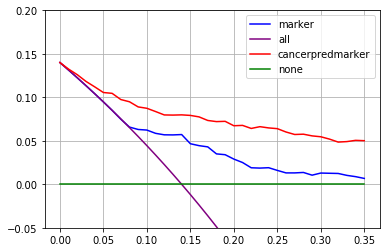

In [20]:
plot_net_benefit_graphs(binary_output_df)

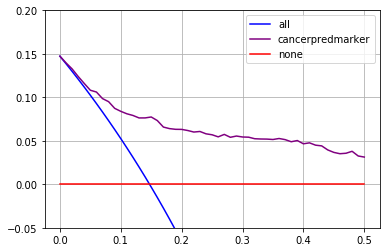

In [21]:
plot_net_benefit_graphs(survival_output_df)

In [ ]:
survival_output_df[survival_output_df['predictor'] == 'cancerpredmarker']

In [ ]:
survival_output_df[survival_output_df['predictor'] == 'all']